# Imports



In [42]:
# TensorFlow imports for model training
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Sci-Kit Learn for helper methods
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight


# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# General
from google.colab import drive

# Constants

In [43]:
# Folders
root_folder = "/content/"
drive_folder = root_folder + "drive/MyDrive/"

# Datasets
train_data_filename = "train_dataset.csv"

# Pre-processing
perform_analysis = True
match_result_columns = ['HomeWin', 'Draw', 'AwayWin']
unnecessary_columns = ['id', 'profit_1', 'profit_x', 'profit_2']

# Training
ignored_features = ['odds_ft_1', 'odds_ft_x', 'odds_ft_2']
perform_cross_fold_validation = True
num_cross_validations = 5

# Testing
perform_test = True
fnn_model_name = "fnn_model.keras"

# Preparing the datasets

## Loading the dataset

In [44]:
# Mount Google Drive
drive.mount('/content/drive/')

data_original = pd.read_csv(drive_folder + train_data_filename, sep=";")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Cleaning the dataset

In [45]:
# Removing unnecessary columns
data_original_cleaned = data_original.drop(columns=unnecessary_columns)

# Dropping rows with empty values
data_original_cleaned = data_original_cleaned.dropna()

## Preparing the train & test datasets

In [46]:
# Shuffling the dataset
data_original_cleaned = data_original_cleaned.sample(
    n=len(data_original_cleaned)
).reset_index(drop=True)

# Doing a 20% split to obtain the blind test data
train_data, test_data = train_test_split(data_original_cleaned, test_size=0.20)
train_data

,team_a_mot_x_pos,team_b_mot_x_pos,team_a_ppg_dif_l4,team_a_ppg_dif_l6,team_b_ppg_dif_l4,team_b_ppg_dif_l6,team_a_ratio_shotsOnTarget_overall,team_a_ratio_shotsOnTarget_l4,team_a_ratio_shotsOnTarget_l6,team_b_ratio_shotsOnTarget_overall,...,team_a_shots_overall_l4_TSR,team_b_shots_overall_l4_TSR,team_a_shots_overall_l6_TSR,team_b_shots_overall_l6_TSR,HomeWin,Draw,AwayWin,odds_ft_1,odds_ft_x,odds_ft_2
52843,0.95,0.52,0.964000,1.041430,0.580000,1.350000,0.398900,0.380435,0.388430,0.394683,...,0.60,0.40,0.57,0.43,1,0,0,1.20,7.00,17.00
42531,0.89,0.63,0.656000,0.498750,1.000000,9.360000,0.540404,0.475000,0.550000,0.485207,...,0.66,0.34,0.57,0.43,1,0,0,1.74,3.30,4.05
23043,0.38,0.60,0.511111,1.302000,0.733333,0.762857,0.498208,0.510204,0.440000,0.502591,...,0.60,0.40,0.64,0.36,1,0,0,1.55,4.00,5.50
30884,0.18,0.17,1.000000,1.333330,0.700000,0.187500,0.401361,0.328947,0.378378,0.404255,...,0.52,0.48,0.51,0.49,1,0,0,2.05,3.75,3.65
34256,0.52,0.48,0.786667,0.771429,2.840000,3.200000,0.483271,0.478261,0.436620,0.505000,...,0.58,0.42,0.60,0.40,1,0,0,1.56,3.70,5.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9519,0.52,0.30,2.590000,0.282000,5.400000,1.284000,0.421405,0.473684,0.421053,0.343575,...,0.47,0.53,0.48,0.52,1,0,0,4.20,4.96,1.58
7312,0.22,0.38,0.860000,0.324000,0.697778,0.960000,0.415771,0.439394,0.494737,0.536232,...,0.56,0.44,0.54,0.46,0,0,1,2.45,3.20,2.85
16554,0.47,0.52,0.752000,0.446667,4.480000,1.740000,0.510989,0.589744,0.541667,0.474860,...,0.47,0.53,0.47,0.53,1,0,0,1.90,3.41,4.75
19502,0.44,0.63,0.857143,0.798000,0.645000,0.445000,0.504902,0.545455,0.477612,0.497797,...,0.58,0.42,0.57,0.43,0,1,0,3.00,2.75,2.35


# Analyzing the data

## Correlation heat map between the different features

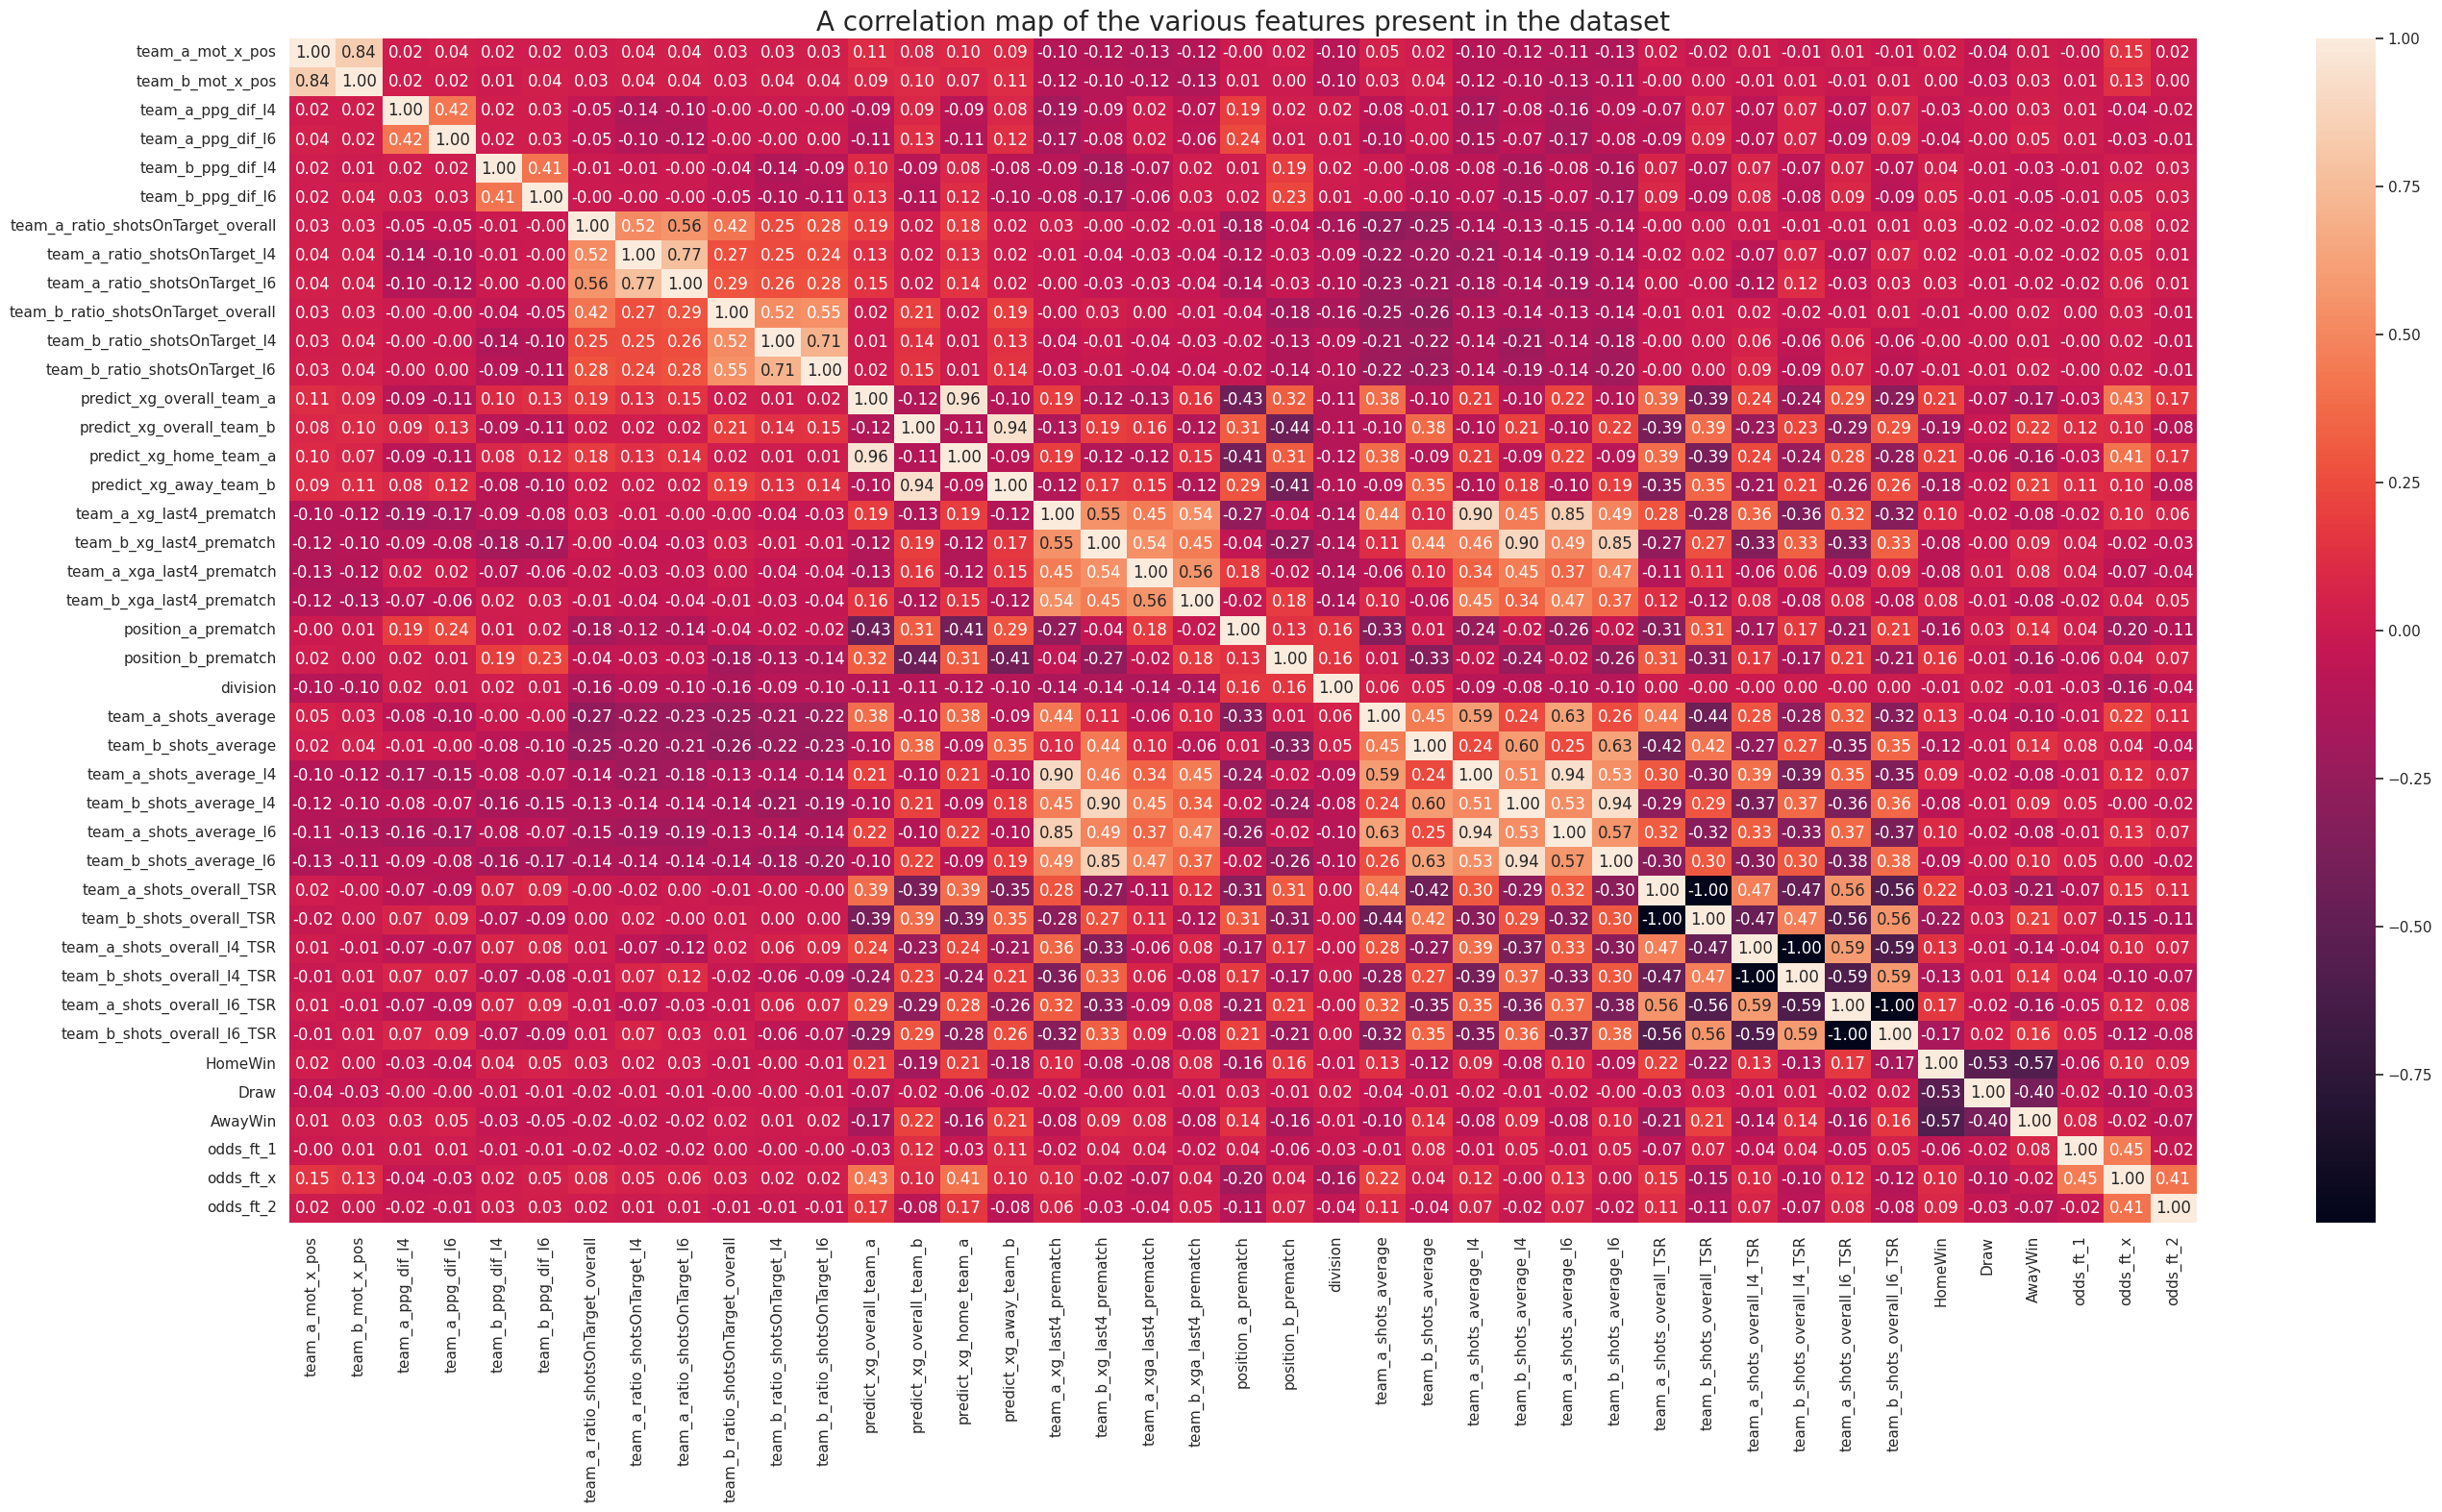

In [47]:
if perform_analysis:
    sns.set(rc={'figure.figsize': (32, 16)})
    sns.heatmap(train_data.corr(), fmt='.2f', annot=True)
    plt.title("A correlation map of the various features present in the dataset",
            fontsize = 20)
    plt.show()

## Visualizing the actual vs predicted count for each match result

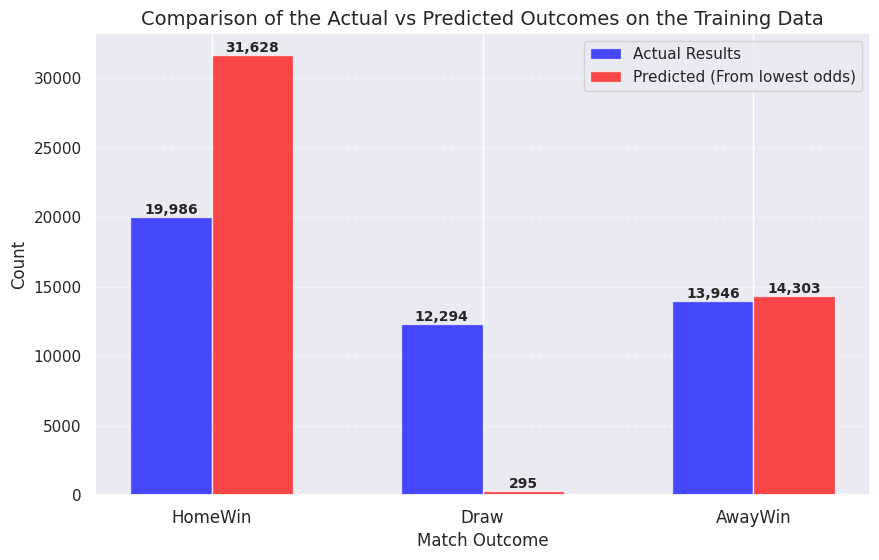

In [48]:
def predict_outcome(odds):
    '''
    Predicts the match outcome from the odds.

    Parameters:
    odds (numpy array): the given odds as a list [home, draw, away]

    Returns:
    String: the prediction based on the lowest odds.
    In case of a tie between draw and either home/home always choose draw.
    In case of a tie between home and away always choose home.
    '''
    min_odd = odds.min()
    # Always favour a draw if it has equal odds with home or away
    if (min_odd == odds.iloc[1] == odds.iloc[0]) or (min_odd == odds.iloc[1] ==
                                                     odds.iloc[2]):
        return match_result_columns[1]
    # if home and away are the same choose home
    elif min_odd == odds.iloc[0] == odds.iloc[2]:
        return match_result_columns[0]
    else:
        return match_result_columns[odds.argmin()]

if perform_analysis:
    # Home, Away, Draw actual count
    actual_results = []
    for match_result in match_result_columns:
        actual_results.append(train_data[(train_data[match_result] == 1)].shape[0])

    # Home, Away, Draw predicted count
    odds_columns = ['odds_ft_1', 'odds_ft_x', 'odds_ft_2']

    predicted_outcomes_from_odds = train_data[odds_columns].apply(predict_outcome,
                                                                  axis=1)

    predicted_results = []
    for match_result in match_result_columns:
        predicted_results.append(len(train_data[
            predicted_outcomes_from_odds == match_result
            ]))

    plt.figure(figsize=(10, 6))

    actual_results_bar = plt.bar(np.arange(len(match_result_columns)) - 0.15,
                                actual_results, 0.3, label='Actual Results',
                                color='blue', alpha=0.7)
    predicted_results_bar = plt.bar(np.arange(len(match_result_columns)) + 0.15,
                                    predicted_results, 0.3,
                                    label='Predicted (From lowest odds)',
                                    color='red', alpha=0.7)

    for bars in [actual_results_bar, predicted_results_bar]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height + 50,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=10,
                    fontweight='bold')

    plt.xlabel('Match Outcome', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Comparison of the Actual vs Predicted Outcomes on the Training Data',
              fontsize=14)
    plt.xticks(np.arange(len(match_result_columns)), match_result_columns,
            fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

## Analyzing the accuracy of the odds

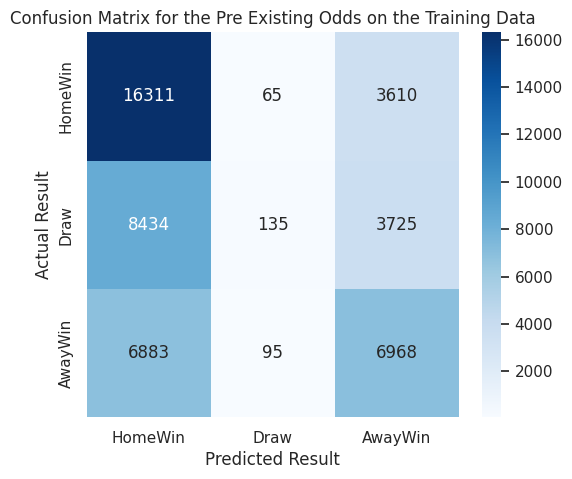


The accuracy of existing odds on the training data is: 50.65%


In [49]:
if perform_analysis:
    odds_cm = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

    for i in range(len(match_result_columns)):
        for j in range(len(match_result_columns)):
            odds_cm[i][j] = train_data[
                (train_data[match_result_columns[i]] == 1) &
                (predicted_outcomes_from_odds == match_result_columns[j])
            ].shape[0]

    odds_cm = np.array(odds_cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(odds_cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=match_result_columns, yticklabels=match_result_columns)

    plt.xlabel("Predicted Result")
    plt.ylabel("Actual Result")
    plt.title("Confusion Matrix for the Pre Existing Odds on the Training Data")
    plt.show()

    odds_accuracy = np.trace(odds_cm) / np.sum(odds_cm) * 100

    print(f"\nThe accuracy of existing odds on the training data is: {odds_accuracy:.2f}%")

## Profit calculation from existing Odds

In [50]:
def profit(data, predicted_outcomes, loss_penalty_factor=1):
    """
    Calculates the total profit based on given predictions and betting odds.

    Parameters:
    data (DataFrame): The dataset containing match results and odds.
    predicted_outcomes (Series): A pandas Series containing predicted outcomes
    (e.g., ['HomeWin', 'Draw', 'AwayWin']).

    Returns:
    float: The total profit calculated from the dataset.
    """

    # Mapping predicted outcomes to corresponding odds columns
    outcome_to_odds = dict(zip(match_result_columns, odds_columns))

    # Check if predictions match actual results (1 = correct, 0 = incorrect)
    correct_prediction_indicator = (data[
        match_result_columns].idxmax(axis=1) == predicted_outcomes).astype(int)

    # Obtain the odds for the prediction
    odds_column_names = predicted_outcomes.map(outcome_to_odds).values
    odds_columns_idx = np.array(
        [odds_columns.index(col) for col in odds_column_names]
    )
    odds_of_prediction = data[odds_columns].to_numpy()[
        np.arange(len(data)), odds_columns_idx
    ]

    profit = np.sum((odds_of_prediction * correct_prediction_indicator) - 1)


    return profit

if perform_analysis:
    profit_from_odds = profit(train_data, predicted_outcomes_from_odds)
    print(f"The calculated profit from the existing odds is {profit_from_odds}")

The calculated profit from the existing odds is -2280.51


# Training the model

## Defining the FNN

In [51]:
def build_FNN_model(input_shape, num_classes):
    '''
    Builds an FNN model for the input.

    Parameters:
    input_shape (Tuple): The input shape of the data.
    num_classes (Int): Number of models

    Returns:
    Sequential: returns the sequential model.
    '''
    # Clear session before retraining
    K.clear_session()

    model = Sequential([
        Input(shape=(input_shape, )),
        Dense(64, kernel_regularizer=regularizers.L2(0.2)),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.2),

        Dense(32, kernel_regularizer=regularizers.L2(0.2)),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.2),

        Dense(32, kernel_regularizer=regularizers.L2(0.2)),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.2),

        Dense(16, kernel_regularizer=regularizers.L2(0.2)),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.2),

        Dense(16, kernel_regularizer=regularizers.L2(0.2)),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.01),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    return model

# Callbacks for training
reduce_lr_fnn = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

## Plotting the metrics

In [52]:
def plot_metrics(history):
    '''
    Plots all the metrics of the model.

    Parameters:
    history (Dictionary): The history of the model runs.
    '''
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plotting the FNN metrics
    axs[0, 0].plot(history.history['accuracy'], label='Training Accuracy',
                   color='blue')
    axs[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy',
                   color='orange')
    axs[0, 0].set_title("Accuracy")
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

    axs[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[0, 1].plot(history.history['val_loss'], label='Validation Loss',
                   color='orange')
    axs[0, 1].set_title("Loss")
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    axs[1, 0].plot(history.history['precision'], label='Training Precision',
                   color='blue')
    axs[1, 0].plot(history.history['val_precision'], label='Validation Precision',
                   color='orange')
    axs[1, 0].set_title("Precision")
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()

    axs[1, 1].plot(history.history['recall'], label='Training Recall',
                   color='blue')
    axs[1, 1].plot(history.history['val_recall'], label='Validation Recall',
                   color='orange')
    axs[1, 1].set_title("Recall")
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()

    fig.suptitle("Summarizing the performance metrics of the model")

    plt.tight_layout()

    plt.show()

## Running the model

In [53]:
def run_model(X_train, y_train, X_test=None, save_model=False):
    '''
    A function to run the FNN model

    Parameters:
    X_train (Dataframe): The X values of the data for training.
    y_train (Dataframe): The y values of the data for training.
    X_test (Dataframe): The X values of the data for testing.

    Returns:
    Tuple (Dataframe, Dictionary): returns the model predictions and history.
    '''
    X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                                    y_train,
                                                                  test_size=0.1)

    y_train_int = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced',
                                         classes=np.unique(y_train_int),
                                         y=y_train_int)

    model = build_FNN_model(X_train.shape[1], len(match_result_columns))

    # Train the model
    print(model.summary())
    history = model.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        epochs=50,
        batch_size=32,
        callbacks=[reduce_lr_fnn],
        class_weight=dict(enumerate(class_weights)),
        verbose=1
    )

    if save_model:
        model.save(fnn_model_name)

    y_preds = []

    if type(X_test) != type(None):
        y_preds = model.predict(X_test)

    return y_preds, history

## Peforming K-fold cross validation

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16)                  │              

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,611 (25.82 KB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3273 - loss: 2.2869 - precision: 0.3763 - recall: 0.0081 - val_accuracy: 0.2793 - val_loss: 1.1394 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3237 - loss: 1.2661 - precision: 0.2846 - recall: 4.1564e-04 - val_accuracy: 0.2793 - val_loss: 1.2853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3326 - loss: 1.3209 - precision: 0.3291 - recall: 7.9146e-04 - val_accuracy: 0.2793 - val_loss: 1.2106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3263 - loss: 1.2322 - precision: 0.3320 - recall: 4.7049e-04 - val_accuracy: 0.2793 - val_loss: 1.1718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 

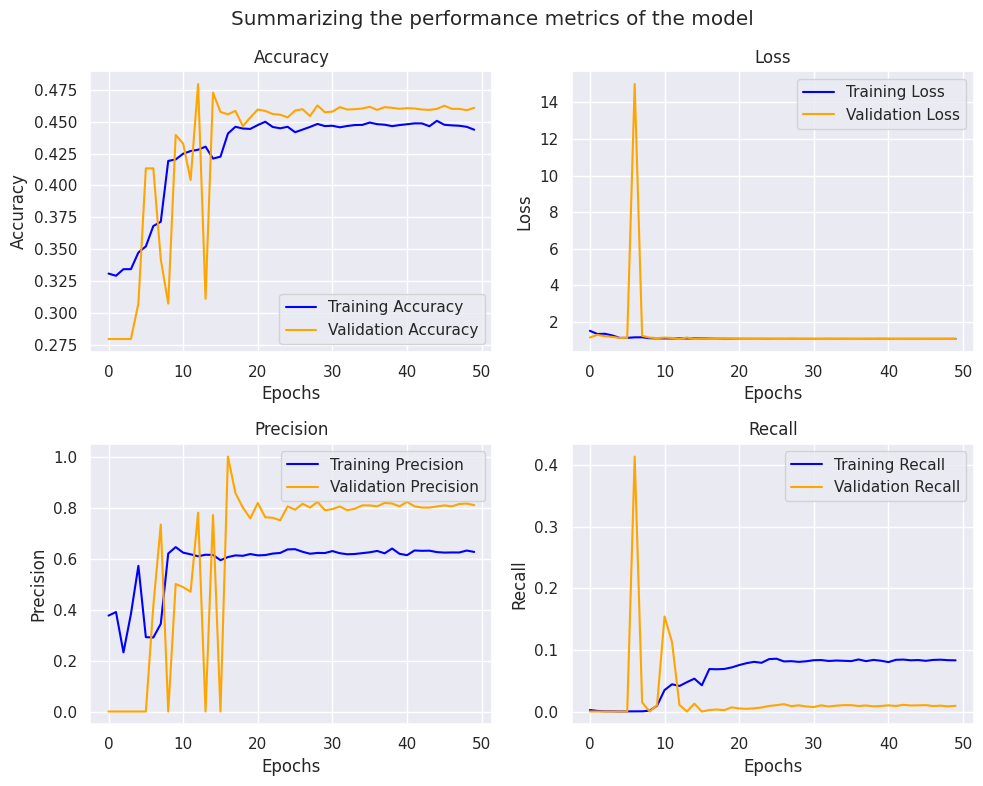

Fold 1 - F1: 0.45295262816353016, Odds profit -367.4, and model profit -364.91999999999996


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16)                  │              

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,611 (25.82 KB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.3307 - loss: 2.2688 - precision: 0.3087 - recall: 0.0065 - val_accuracy: 0.2569 - val_loss: 1.1772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3272 - loss: 1.1801 - precision: 0.1717 - recall: 1.7457e-04 - val_accuracy: 0.3042 - val_loss: 1.1141 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3174 - loss: 1.3031 - precision: 0.2956 - recall: 6.5201e-04 - val_accuracy: 0.2569 - val_loss: 1.1711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3286 - loss: 1.4310 - precision: 0.3587 - recall: 0.0015 - val_accuracy: 0.2569 - val_loss: 1.1326 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 5/5

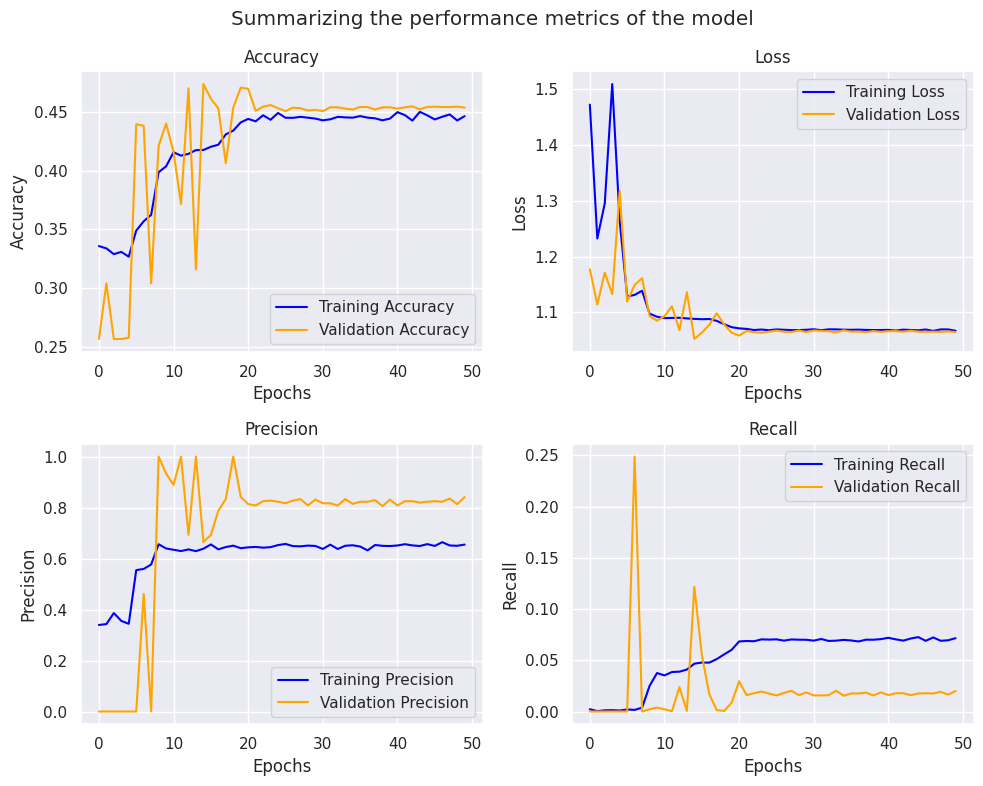

Fold 2 - F1: 0.4431105342850963, Odds profit -578.1300000000001, and model profit -712.34


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16)                  │              

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,611 (25.82 KB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.3345 - loss: 2.2452 - precision: 0.3677 - recall: 0.0111 - val_accuracy: 0.4243 - val_loss: 2.9747 - val_precision: 0.4249 - val_recall: 0.4205 - learning_rate: 0.1000
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3263 - loss: 1.6203 - precision: 0.1596 - recall: 2.2064e-04 - val_accuracy: 0.2677 - val_loss: 1.1276 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3266 - loss: 1.1900 - precision: 0.1644 - recall: 2.6352e-04 - val_accuracy: 0.4243 - val_loss: 1.1391 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3297 - loss: 1.2164 - precision: 0.0434 - recall: 2.4731e-05 - val_accuracy: 0.4243 - val_loss: 1.6049 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 5/50
10

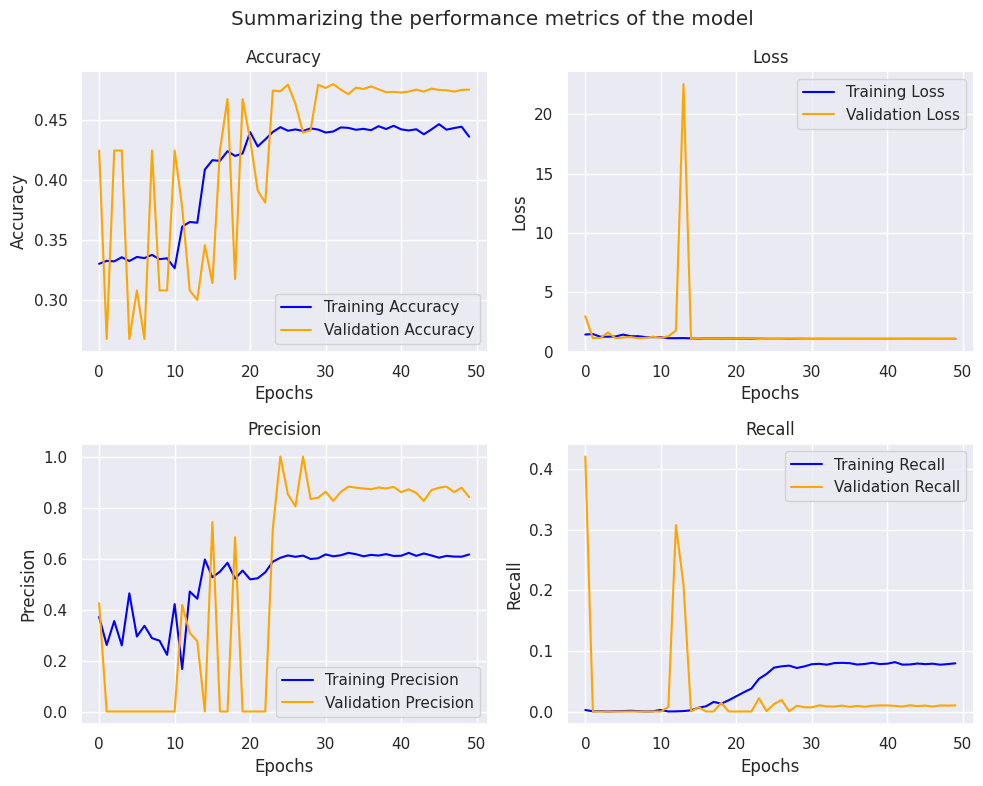

Fold 3 - F1: 0.4718797317759031, Odds profit -556.41, and model profit -366.9699999999999


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16)                  │              

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,611 (25.82 KB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.3306 - loss: 2.1728 - precision: 0.3836 - recall: 0.0108 - val_accuracy: 0.4381 - val_loss: 1.1612 - val_precision: 0.4782 - val_recall: 0.3380 - learning_rate: 0.1000
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3294 - loss: 1.2490 - precision: 0.2757 - recall: 1.7070e-04 - val_accuracy: 0.4218 - val_loss: 1.1264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3287 - loss: 1.2586 - precision: 0.2811 - recall: 0.0025 - val_accuracy: 0.4218 - val_loss: 1.1508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3370 - loss: 1.2837 - precision: 0.2650 - recall: 0.0020 - val_accuracy: 0.2864 - val_loss: 1.6506 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 5/50
1041/1041 ━

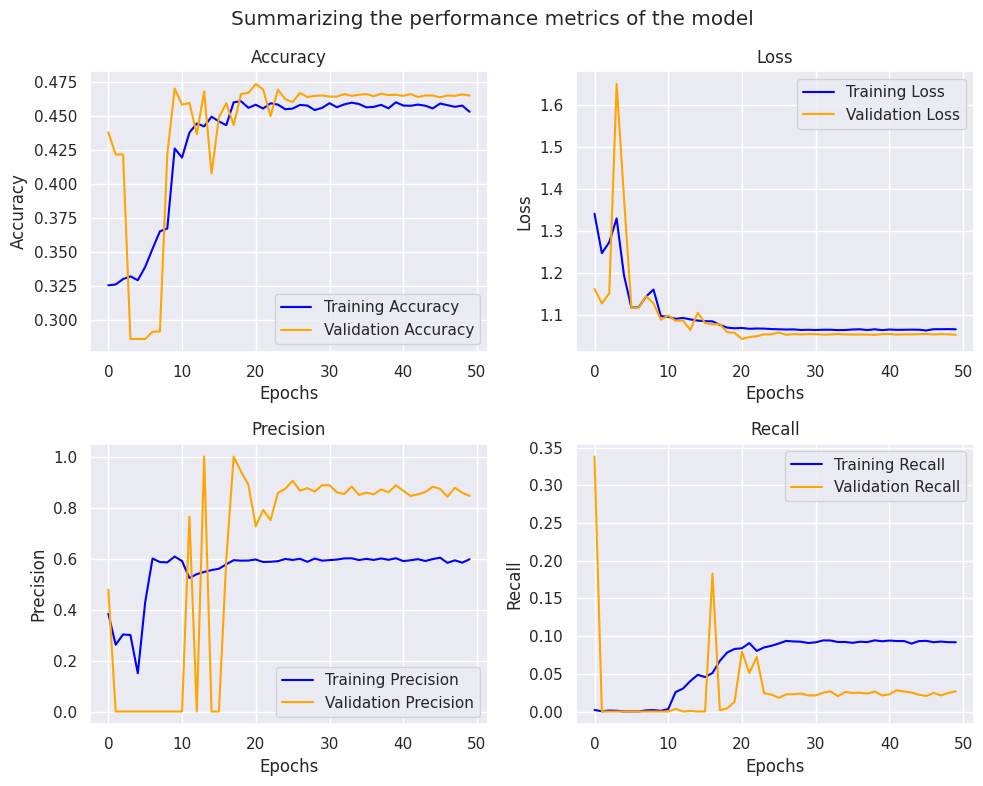

Fold 4 - F1: 0.4747999134760978, Odds profit -712.83, and model profit -452.66999999999996


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16)                  │              

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,611 (25.82 KB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.3244 - loss: 2.1324 - precision: 0.3712 - recall: 0.0067 - val_accuracy: 0.4378 - val_loss: 1.1885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3389 - loss: 1.3818 - precision: 0.1838 - recall: 2.9575e-04 - val_accuracy: 0.4378 - val_loss: 1.5172 - val_precision: 0.4408 - val_recall: 0.0251 - learning_rate: 0.1000
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3204 - loss: 1.3222 - precision: 0.4351 - recall: 0.0012 - val_accuracy: 0.4378 - val_loss: 1.2551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3448 - loss: 1.6274 - precision: 0.3423 - recall: 0.0014 - val_accuracy: 0.2985 - val_loss: 1.2278 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 5/50
1041/1041

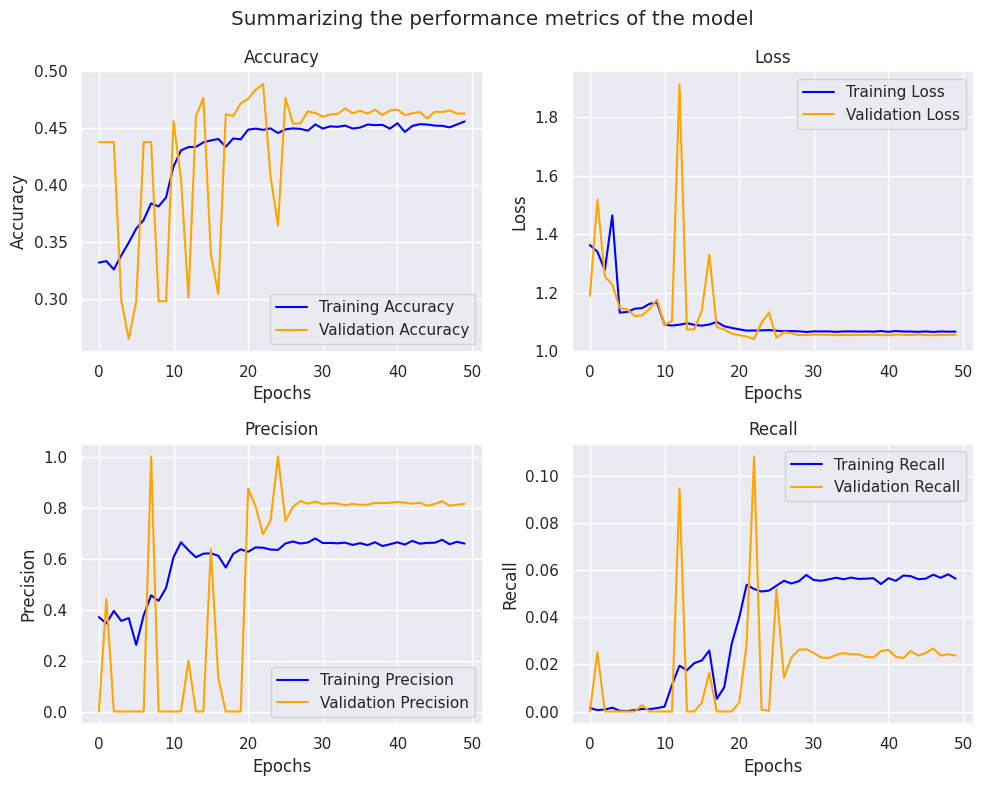

Fold 5 - F1: 0.47966688297642224, Odds profit -209.46999999999997, and model profit -233.07999999999996
F1 mean: 0.46448193813540994 and std-dev: 0.014010227740217769
Odds profits mean: -484.84799999999996 and std-dev: 176.30968168537999
Model profits mean: -425.996 and std-dev: 159.45865804025823


In [54]:
if perform_cross_fold_validation:
    f1_scores = []
    odds_profits = []
    model_profits = []

    for i in range(num_cross_validations):
        train_data_temp, test_data_temp = train_test_split(train_data,
                                            test_size=1/num_cross_validations)

        X_train = train_data_temp.drop(match_result_columns + ignored_features,
                                       axis=1)
        y_train = train_data_temp[match_result_columns]

        X_test = test_data_temp.drop(match_result_columns + ignored_features,
                                     axis=1)
        y_test = test_data_temp[match_result_columns]

        y_preds, history = run_model(X_train, y_train, X_test)

        plot_metrics(history)
        y_preds_classes = [match_result_columns[i]
                           for i in np.argmax(y_preds, axis=1)]
        y_actual_classes = [match_result_columns[i]
                            for i in np.argmax(y_test, axis=1)]

        f1 = f1_score(y_actual_classes, y_preds_classes, average='micro')
        f1_scores.append(f1)

        predicted_outcomes_from_odds = test_data_temp[odds_columns].apply(predict_outcome,
                                                                          axis=1)

        odds_profit = profit(test_data_temp, predicted_outcomes_from_odds)
        odds_profits.append(odds_profit)

        model_profit = profit(test_data_temp, pd.Series(y_preds_classes,
                                                   index=test_data_temp.index,
                                                   name='Predicted Result'))

        model_profits.append(model_profit)

        print(f"Fold {i+1} - F1: {f1}, Odds profit {odds_profit}, and model profit {model_profit}")


    print(f"F1 mean: {np.mean(f1_scores)} and std-dev: {np.std(f1_scores)}")
    print(f"Odds profits mean: {np.mean(odds_profits)} and std-dev: {np.std(odds_profits)}")
    print(f"Model profits mean: {np.mean(model_profits)} and std-dev: {np.std(model_profits)}")

# Evaluating the model on blind test data

## Training the model on all the data and running it on test data

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16)                  │              

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,611 (25.82 KB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3321 - loss: 2.0371 - precision: 0.3277 - recall: 0.0068 - val_accuracy: 0.2648 - val_loss: 1.1383 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3276 - loss: 1.2535 - precision: 0.1314 - recall: 2.1056e-04 - val_accuracy: 0.4426 - val_loss: 1.1058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3431 - loss: 1.2700 - precision: 0.2775 - recall: 7.6246e-04 - val_accuracy: 0.2648 - val_loss: 1.1536 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3347 - loss: 1.2149 - precision: 0.2863 - recall: 3.7240e-04 - val_accuracy: 0.4426 - val_loss: 1.1141 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch

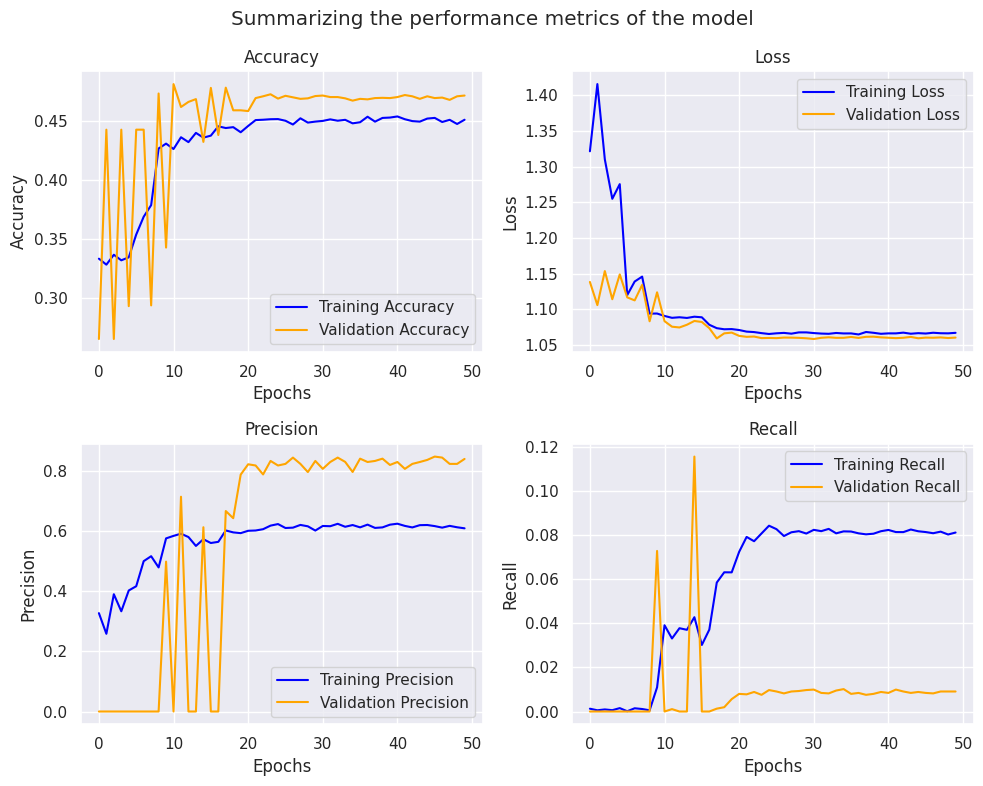

In [55]:
if perform_test:
    # Training a model on all the training data
    X_train = train_data.drop(match_result_columns + ignored_features, axis=1)
    y_train = train_data[match_result_columns]

    X_test = test_data.drop(match_result_columns + ignored_features, axis=1)
    y_test = test_data[match_result_columns]

    y_preds, history = run_model(X_train, y_train, X_test, save_model=True)

    plot_metrics(history)

    y_preds_classes = [match_result_columns[i] for i in np.argmax(y_preds, axis=1)]
    y_actual_classes = [match_result_columns[i] for i in np.argmax(y_test, axis=1)]

## Generating a confusion matrix and a detailed report of the model on the test data

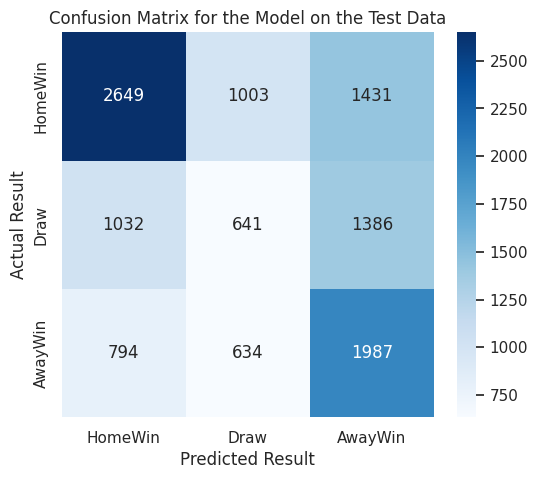

              precision    recall  f1-score       support
HomeWin        0.413614  0.581845  0.483514   3415.000000
Draw           0.281387  0.209546  0.240210   3059.000000
AwayWin        0.591955  0.521149  0.554300   5083.000000
accuracy       0.456606  0.456606  0.456606      0.456606
macro avg      0.428985  0.437513  0.426008  11557.000000
weighted avg   0.457053  0.456606  0.450247  11557.000000

The accuracy of the model on the test data is: 45.66%


In [56]:
if perform_test:
    model_test_cm = confusion_matrix(y_actual_classes, y_preds_classes,
                                     labels=match_result_columns)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(model_test_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=match_result_columns,
                yticklabels=match_result_columns)
    plt.xlabel("Predicted Result")
    plt.ylabel("Actual Result")
    plt.title("Confusion Matrix for the Model on the Test Data")
    plt.show()

    # Print classification report
    report = classification_report(y_actual_classes, y_preds_classes,
                                target_names=match_result_columns,
                                zero_division=1, output_dict=True)

    # Convert to DataFrame for better visualization
    report_df = pd.DataFrame(report).T
    print(report_df)

    model_accuracy_test = np.trace(model_test_cm) / np.sum(model_test_cm) * 100
    print(f"\nThe accuracy of the model on the test data is: {model_accuracy_test:.2f}%")

## Generating a confusion matrix from the odds on the test data

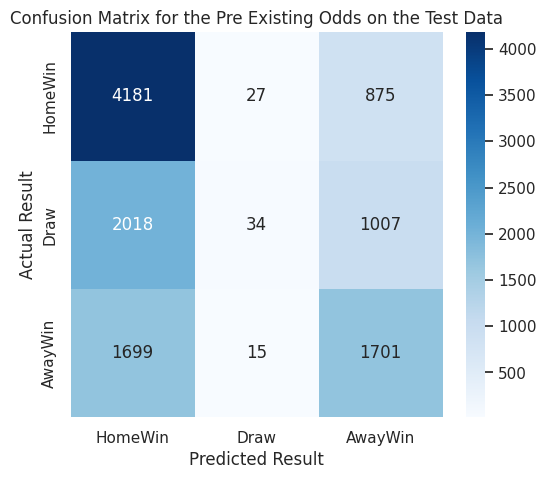


The accuracy of existing odds on the test data is: 51.19%


In [57]:
if perform_test:
    predicted_outcomes_from_odds_test = test_data[odds_columns].apply(predict_outcome,
                                                                      axis=1)
    odds_test_cm = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

    for i in range(len(match_result_columns)):
        for j in range(len(match_result_columns)):
            odds_test_cm[i][j] = test_data[
                (test_data[match_result_columns[i]] == 1) &
                (predicted_outcomes_from_odds_test == match_result_columns[j])
            ].shape[0]

    odds_test_cm = np.array(odds_test_cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(odds_test_cm, annot=True, fmt="d", cmap="Blues",
                cbar=True, xticklabels=match_result_columns,
                yticklabels=match_result_columns)

    plt.xlabel("Predicted Result")
    plt.ylabel("Actual Result")
    plt.title("Confusion Matrix for the Pre Existing Odds on the Test Data")
    plt.show()

    odds_accuracy_test = np.trace(odds_test_cm) / np.sum(odds_test_cm) * 100

    print(f"\nThe accuracy of existing odds on the test data is: {odds_accuracy_test:.2f}%")

## Calculating the profit on the test data

In [58]:
if perform_test:
    profit_from_odds = profit(test_data, predicted_outcomes_from_odds_test)
    print(f"The calculated profit from the existing odds is {profit_from_odds}")

    y_preds_series = pd.Series(y_preds_classes, index=test_data.index,
                            name='Predicted Result')

    profit_from_model = profit(test_data, y_preds_series)
    print(f"The calculated profit from the model is: {profit_from_model}")
    print(f"The profit gain after running the model is:  {profit_from_model - profit_from_odds}")

The calculated profit from the existing odds is -451.81
The calculated profit from the model is: -732.21
The profit gain after running the model is:  -280.40000000000003


# Sources


- [The dataset](https://www.kaggle.com/competitions/prediction-of-results-in-soccer-matches/overview)
- [A brief of description of fivethirtyeight](https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/)
- [The accuracy of fivethirtyeight](https://projects.fivethirtyeight.com/checking-our-work/)
- [A random forest soccer prediction model](https://www.researchgate.net/publication/378355415_Soccer_match_outcome_prediction_with_random_forest_and_gradient_boosting_models)
- [A neural network soccer prediction model](https://ieeexplore.ieee.org/document/9720896)
- [A discussion on soccer analytics](https://socceranalytics.org.uk/predictions-in-soccer/)